<a href="https://colab.research.google.com/github/marmarmarmar/fun-with-cifar10/blob/master/Tooploox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tooplox data exercise

In this notebook we will go through Tooploox data exercise.

We will use Keras as a base for simplicity of NN computations. Let us start with data collection and splitting:

In [1]:
from keras.datasets import cifar10

VALID_SIZE = 1000

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train, y_test = y_train.flatten(), y_test.flatten()

x_train = x_train[::10]
x_test = x_test[::10]
y_train = y_train[::10]
y_test = y_test[::10]

x_valid, y_valid = x_train[:VALID_SIZE], y_train[:VALID_SIZE]
x_train, y_train = x_train[VALID_SIZE:], y_train[VALID_SIZE:] 

Using TensorFlow backend.


Now - let us have a look at the example images:

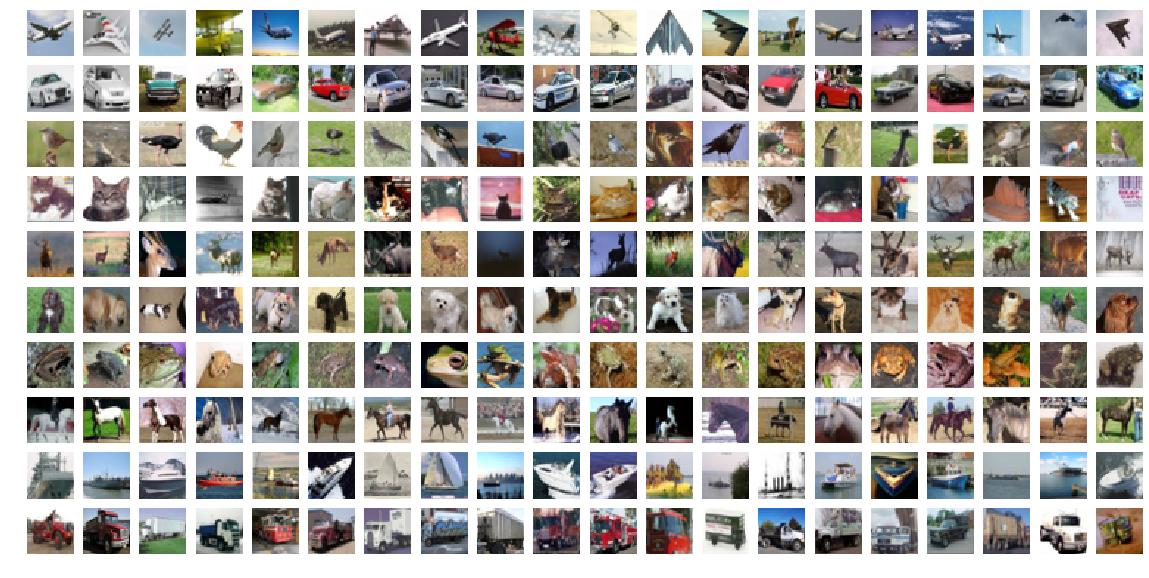

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_SEED = 42


def get_random_images_for_class(
    images,
    labels,
    class_, 
    nb_of_images,
    random_seed=RANDOM_SEED,
):
    class_indices = np.arange(images.shape[0])[labels.flatten() == class_]
    random_indices = np.random.RandomState(
        seed=42,
    ).permutation(class_indices)[:nb_of_images]
    return images[random_indices]


def plot_images(images, labels, nb_of_images_in_row=20, random_seed=RANDOM_SEED):
    overall_count = 1
    plt.figure(figsize=(nb_of_images_in_row, 10))
    for class_nb in range(10):
        for image_nb, image in enumerate(get_random_images_for_class(
        images=images,
        labels=labels,
        class_=class_nb,
        nb_of_images=nb_of_images_in_row,
        random_seed=random_seed,
    )):
          plt.subplot(10, nb_of_images_in_row, overall_count)
          plt.imshow(image)
          plt.axis('off')
          overall_count += 1
    plt.show()
    
    
plot_images(x_train, y_train)

## Baseline preparation:

In order to perform a baseline evaluation - let us start with computations of a HOG features. We will also introduce a general interface  `ImageVectors` for embedding images into more meaningful, semantical vector space.

In [0]:
from skimage.feature import hog
  

class ImageVectors:
  
    def embedd_images(self, images):
        raise NotImplementedError
      

class HOGImageVectors:
    
    def embedd_images(self, images):
        return np.array([hog(image) for image in images])

Now - let us prepare an object which will perform experiments. The class `TooplooxExperiment` will cover all functionalities needed by an exercise, namely model training and data visualization.

In [0]:
DEFAULT_VISUALIZATION_POINTS = 500


class TooplooxExperiment:
  
    def __init__(
        self,
        visualization_transformer,
        nb_of_visualization_points,
        images_transformer,
        cv_instance,
    ):
        self.visualization_transformer = visualization_transformer
        self.nb_of_visualization_points = nb_of_visualization_points
        self.images_transformer = images_transformer
        self.cv_instance = cv_instance
        
    def visualize_points(self, points, targets):
        transformed_points = self.transform_points_for_visualization(points)
        self.visualize_points_for_classes(
            points=transformed_points,
            targets=targets
        )
        
    def transform_points_for_visualization(self, points):
        return self.visualization_transformer.fit_transform(
            points[:self.nb_of_visualization_points])
      
    def visualize_points_for_classes(self, points, targets):
        targets = targets.flatten()
        for class_nb in range(10):
            plt.scatter(
                points[
                    targets[:self.nb_of_visualization_points] == class_nb, 0
                ],
                points[
                    targets[:self.nb_of_visualization_points] == class_nb, 1
                ],
                alpha=0.5,
        )
        plt.show()
        
    def fit_on_points(self, points, targets):
        targets = targets.flatten()
        self.cv_instance.fit(points, targets)
        
    def perform_experiment(self, images, targets):
        points = self.images_transformer.embedd_images(images)
        self.visualize_points(points, targets)
        self.cv_instance.fit(points, targets)
        print('Best score = %f' % self.cv_instance.best_score_)
        
    def predict(self, images):
        points = self.images_transformer.embedd_images(images)
        predictions = self.cv_instance.predict(points)
        return predictions
        
    def score(self, images, targets):
        predictions = self.predict(images)
        return (predictions == targets).mean()

Now - we can perform a first experiment using `HOG` vectors. We will also implement a `sklearn` pipeline which will perform training. We will start from dimensionality reduction technique called `PCA` on a standarized data. Then we will try different options of `SVM` for mutliclassification.

In [0]:
from sklearn import decomposition
from sklearn import manifold
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm


svm_pipeline = pipeline.Pipeline(
    steps=[
        ('preprocessor', preprocessing.StandardScaler()),
        ('pca', decomposition.PCA()),
        ('svm_model', svm.LinearSVC(dual=False)),
    ]
)


svm_grid = {
    'pca__n_components': [64, 128, 256],
    'svm_model__penalty': ['l1', 'l2'],
    'svm_model__C': [0.1, 1.0, 10.0],
}



def build_cv(cv=3, verbose=0, n_jobs=3):
    return model_selection.GridSearchCV(
        estimator=svm_pipeline,
        param_grid=svm_grid,
        cv=cv,
        verbose=verbose,
        n_jobs=n_jobs,
    )


class HOGTooplooxExperiment(TooplooxExperiment):
    
    def __init__(
        self,
        visualization_transformer,
        nb_of_visualization_points,
        cv_instance,
    ):
        super().__init__(
            visualization_transformer=visualization_transformer,
            nb_of_visualization_points=nb_of_visualization_points,
            images_transformer=HOGImageVectors(),
            cv_instance=cv_instance,
        )
          
    @classmethod
    def build_default(cls):
        return cls(
            visualization_transformer=manifold.TSNE(2),
            cv_instance=build_cv(),
            nb_of_visualization_points=DEFAULT_VISUALIZATION_POINTS,
        )
      

hog_experiment = HOGTooplooxExperiment.build_default()

Having a built experiment object - now we can perform it using `HOG` vectors.

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


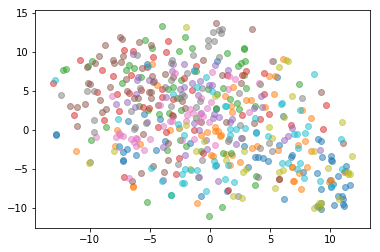

Best score = 0.459250


In [6]:
hog_experiment.perform_experiment(x_train, y_train)

As we may see  - the `HOG` vectors have some discriminative power. The score is pretty low - 44%, but let us compare it with next models. One should not use more complexed methods if it does not surpass a simple method like `HOG`. Now let us try a `ResNet50` model. We will also introduce `KeasImageVectors` interface - which will be later used for importing and reusing `Keras` models:



In [7]:
import numpy as np
from keras import applications
from keras import layers
from keras import models


class KerasImageVectors(ImageVectors):
  
  def __init__(self):
      self.model = self.build_cifar_10_model()
      
  def build_cifar_10_model(self):
      raise NotImplementedError

  def normalize_images(self, images):
      raise NotImplementedError
    
  def postproces_vectors(self, vectors):
      raise NotImplementedError
      
  def embedd_images(self, images: np.array) -> np.array:
      return self.postprocess_vectors(
          vectors=self.model.predict(self.normalize_images(images)),
      )
    
    
class ResNetKerasImageVectors(KerasImageVectors):
    
    def build_cifar_10_model(self):
        return applications.resnet50.ResNet50(include_top=False)
      
    def upsample(self, images):
        return images
    
    def normalize_images(self, images):
        return applications.resnet50.preprocess_input(
            self.upsample(images),
        )
      
    def postprocess_vectors(self, vectors):
        return vectors.reshape((vectors.shape[0], -1))
      
      
class ResNet50TooplooxExperiment(TooplooxExperiment):
    
    def __init__(
        self,
        visualization_transformer,
        nb_of_visualization_points,
        cv_instance,
    ):
        super().__init__(
            visualization_transformer=visualization_transformer,
            nb_of_visualization_points=nb_of_visualization_points,
            images_transformer=ResNetKerasImageVectors(),
            cv_instance=cv_instance,
        )
          
    @classmethod
    def build_default(cls):
        return cls(
            visualization_transformer=manifold.TSNE(2),
            cv_instance=build_cv(),
            nb_of_visualization_points=DEFAULT_VISUALIZATION_POINTS,
        )
      

resnet_experiment = ResNet50TooplooxExperiment.build_default()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Now - let us perform an experiment using `ResNet50` embedding:

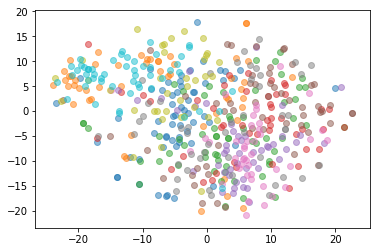

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best score = 0.568750


In [8]:
resnet_experiment.perform_experiment(x_train, y_train)

As we may see an accuracy score increased to over 57%. The discriminative power might be seen on a T-SNE visualization - where one may see almost a single class blobs. Now - let us try a little bit older architecture - namely `VGG16`.

In [0]:
class VGG16KerasImageVectors(KerasImageVectors):
    
    def build_cifar_10_model(self):
        return applications.vgg16.VGG16(include_top=False)
      
    def upsample(self, images):
        return images
    
    def normalize_images(self, images):
        return applications.vgg16.preprocess_input(
            self.upsample(images),
        )
      
    def postprocess_vectors(self, vectors):
        return vectors.reshape((vectors.shape[0], -1))

      
class VGG16TooplooxExperiment(TooplooxExperiment):
    
    def __init__(
        self,
        visualization_transformer,
        nb_of_visualization_points,
        cv_instance,
    ):
        super().__init__(
            visualization_transformer=visualization_transformer,
            nb_of_visualization_points=nb_of_visualization_points,
            images_transformer=VGG16KerasImageVectors(),
            cv_instance=cv_instance,
        )
          
    @classmethod
    def build_default(cls):
        return cls(
            visualization_transformer=manifold.TSNE(2),
            cv_instance=build_cv(),
            nb_of_visualization_points=DEFAULT_VISUALIZATION_POINTS,
        )
      

vgg_experiment = VGG16TooplooxExperiment.build_default()

And perform the experiment:

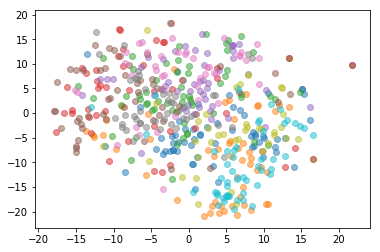

Best score = 0.570000


In [10]:
vgg_experiment.perform_experiment(x_train, y_train)

As we may see - result is almost the same. `T-SNE` visualization also does not seem to be much different (note that if you have run the notebook on your own - results might differ). Now - let us try `InceptionV3` model. Note that in this case an upsampling is needed in order to perform the experiment:

In [0]:
from skimage import transform as sk_transform


class InceptionV3KerasImageVectors(KerasImageVectors):
    
    def build_cifar_10_model(self):
        return applications.inception_v3.InceptionV3(include_top=False)
      
    def upsample(self, images):
        result = np.repeat(np.repeat(images, 5, axis=1), 5, axis=2)
        return result
    
    def normalize_images(self, images):
        return applications.inception_v3.preprocess_input(
            self.upsample(images),
        )
      
    def postprocess_vectors(self, vectors):
        return vectors.reshape((vectors.shape[0], -1))
      
      
class InceptionV3TooplooxExperiment(TooplooxExperiment):
    
    def __init__(
        self,
        visualization_transformer,
        nb_of_visualization_points,
        cv_instance,
    ):
        super().__init__(
            visualization_transformer=visualization_transformer,
            nb_of_visualization_points=nb_of_visualization_points,
            images_transformer=InceptionV3KerasImageVectors(),
            cv_instance=cv_instance,
        )
          
    @classmethod
    def build_default(cls):
        return cls(
            visualization_transformer=manifold.TSNE(2),
            cv_instance=build_cv(),
            nb_of_visualization_points=DEFAULT_VISUALIZATION_POINTS,
        )
      

inception_experiment = InceptionV3TooplooxExperiment.build_default()

Now - we can perform the experiment:

In [0]:
inception_experiment.perform_experiment(x_train, y_train)

As we may see - the score increased by a significant margin to approximately 80%. Also `T-SNE` visualization shows the discriminative power of `InceptionV3` features. 

Now let us confirm that `InceptionV3` provides the best set of features. We will perform a validation set confirmation:

In [0]:
model_dict = {
    'hog': hog_experiment,
    'resnet': resnet_experiment,
    'inceptionv3': inception_experiment,
    'vgg16': vgg_experiment,
}

model_valid_scores = {model_name: model.score(x_valid, y_valid)
                      for model_name, model in model_dict.items()}
print(model_valid_scores)

As we may see - the `Inceptionv3` confirm its result also on validation set. Now - let's perform the final validation on a test set:

In [0]:
model_dict['inceptionv3'].score(x_test, y_test)